# Bayesian Networks to study the factors affecting the population of PacificWalrus

Implementation in **libpgm**

#### Part 1
## Model Construction

In [1]:
import json

from libpgm.nodedata import NodeData
from libpgm.graphskeleton import GraphSkeleton
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork

In [2]:
nd = NodeData()
skel = GraphSkeleton()

All the information of variables/nodes in the network and edges has been formatted in to JSON format (**network.json**) as expected by libpgm. Network was constructed as-is in the original paper

In [3]:
nd.load('network.json')
skel.load('network.json')

In [4]:
skel.toporder()

bn = DiscreteBayesianNetwork(skel, nd)

In [5]:
from libpgm.tablecpdfactorization import TableCPDFactorization

fn = TableCPDFactorization(bn)

In [6]:
from libpgm.sampleaggregator import SampleAggregator

agg = SampleAggregator()

In [18]:
from time import time

b = time()
s = fn.gibbssample(evidence=dict(), n=1000)
print "Finished sampling in ",round(time()-b, 2), "seconds"

Finished sampling in  568.87 seconds


In [19]:
r = agg.aggregate(s)
r['SIEsumfal']

{u'both': 0.439, u'insufficient': 0.125, u'one': 0.436}

#### Part 2
## Choosing an inference algorithm

By running the query **Q** from **Section 3 in Report**

In [7]:
from time import time

b = time()
setOne = fn.gibbssample(evidence=dict(SIEall="insufficient"), n=1000)
print "Finished sampling in ",round(time()-b, 2), "seconds"

Finished sampling in  458.65 seconds


In [9]:
approxOne = agg.aggregate(setOne)

approxOne['SIEsumfal']

{u'both': 0.334, u'insufficient': 0.285, u'one': 0.381}

In [10]:
from time import time

b = time()
setTwo = fn.gibbssample(evidence=dict(SIEall="insufficient"), n=2000)
print "Finished sampling in ",round(time()-b, 2), "seconds"

Finished sampling in  1012.01 seconds


In [11]:
approxTwo = agg.aggregate(setTwo)

approxTwo['SIEsumfal']

{u'both': 0.282, u'insufficient': 0.3025, u'one': 0.4155}

In [8]:
from time import time

b = time()
fn = TableCPDFactorization(bn)
setThree = fn.gibbssample(evidence=dict(SIEall="insufficient"), n=2500)
print "Finished sampling in ",round(time()-b, 2), "seconds"

Finished sampling in  1140.81 seconds


In [9]:
approxThree = agg.aggregate(setThree)

approxThree['SIEsumfal']

{u'both': 0.2468, u'insufficient': 0.4484, u'one': 0.3048}

In [14]:
from time import time

b = time()
fn = TableCPDFactorization(bn)
setFour = fn.gibbssample(evidence=dict(SIEall="insufficient"), n=1500)
print "Finished sampling in ",round(time()-b, 2), "seconds"

Finished sampling in  713.47 seconds


In [15]:
approxFour = agg.aggregate(setFour)

approxFour['SIEsumfal']

{u'both': 0.25066666666666665,
 u'insufficient': 0.436,
 u'one': 0.31333333333333335}

In [8]:
from time import time

b = time()
exactOne = bn.specificquery(dict(SIEsumfal=["both"]), dict(SIEall="insufficient"))
print "Finished exact inference in ", round(time()-b,2)," seconds"
exactTwo = bn.specificquery(dict(SIEsumfal=["one"]), dict(SIEall="insufficient"))
exactThree = bn.specificquery(dict(SIEsumfal=["insufficient"]), dict(SIEall="insufficient"))
print "Probability that SIEsumfal = 'sufficient in both seas' is ",exactOne
print "Probability that SIEsumfal = 'sufficient in one sea' is ",exactTwo
print "Probability that SIEsumfal = 'insufficient in both seas' is ",exactThree

Finished exact inference in  5.64  seconds
Probability that SIEsumfal = 'sufficient in both seas' is  0.200448
Probability that SIEsumfal = 'sufficient in one sea' is  0.295104
Probability that SIEsumfal = 'insufficient in both seas' is  0.504448


#### Part 3
## Answering queries

#### Question
### Insufficient ice cover in which season has a stronger influence?

In [79]:
evidence = dict(SIEall="insufficient")

querySummer = dict(SIEsumfal=["insufficient"])
queryWinter = dict(SIEwin=["insufficient"])
querySpring = dict(SIEspr=["insufficient"])

summer = TableCPDFactorization(bn).specificquery(querySummer, evidence)
winter = TableCPDFactorization(bn).specificquery(queryWinter, evidence)
spring = TableCPDFactorization(bn).specificquery(querySpring, evidence)

print "Probability for Fall/Summer: ",summer
print "Probability for Winter: ",winter
print "Probability for Spring: ",spring

Probability for Fall/Summer:  0.504448
Probability for Winter:  0.427552
Probability for Spring:  0.3592


**Answer:** Insufficient icecover throughout the year is more likely to be caused by insufficient ice cover in Summer

#### Question
### Insufficient ice cover in which sea has a stronger influence? Chukchi Sea or Bering Sea?

In [81]:
evidence = dict(SIEsumfal="insufficient")

queryChukchi = dict(IceCsumfal=["0 to 10"])
queryBering = dict(IceBsumfal=["0 to 10"])

chukchi = bn.specificquery(queryChukchi, evidence)
bering = bn.specificquery(queryBering, evidence)

print "Probability for Chukchi Sea: ", chukchi
print "Probability for Bering Sea: ", bering

Probability for Chukchi Sea:  0.384615384615
Probability for Bering Sea:  0.714285714286


**Answer:** Ice cover of **<10%** in Bering Sea is more likely to cause insufficient ice cover for Walrus sustenance than that of Chukchi Sea.

#### Question
### What is the worse that could happen because of insufficient ice cover?

#### (Contrast this answer to human caused direct impacts in subsequent questions)

In [83]:
evidence = dict(SIEall="insufficient")

queryRobust = dict(AllOutCJ=["robust"])
queryPersistent = dict(AllOutCJ=["persistent"])
queryVulnerable = dict(AllOutCJ=["vulnerable"])
queryRare = dict(AllOutCJ=["rare"])
queryExtirpated = dict(AllOutCJ=["extirpation"])

robust = bn.specificquery(queryRobust, evidence)
persistent = bn.specificquery(queryPersistent, evidence)
vulnerable = bn.specificquery(queryVulnerable, evidence)
rare = bn.specificquery(queryRare, evidence)
extirpated = bn.specificquery(queryExtirpated, evidence)

print "Probability that the population will be Robust: ", robust
print "Probability that the population will be Persistent: ", persistent
print "Probability that the population will be Vulnerable: ", vulnerable
print "Probability that the population will be Rare: ", rare
print "Probability that the population will be Extirpated: ", extirpated

Probability that the population will be Robust:  0.0
Probability that the population will be Persistent:  0.150033805833
Probability that the population will be Vulnerable:  0.301983755664
Probability that the population will be Rare:  0.184682960683
Probability that the population will be Extirpated:  0.363299477821


**Answer:** Population of walrus is more likely to be vulnerable by the end of the year if the ice cover is insufficient.

#### Question
### What are the indirect impacts of human activities (not including hunting or illegal activities) on Total Mortality?

In [85]:
evidence = dict(HUMwin="high", SATwin="high")

queryLow = dict(TMwin=["low"])
queryModerate = dict(TMwin=["moderate"])
queryHigh = dict(TMwin=["high"])

low = bn.specificquery(queryLow, evidence)
moderate = bn.specificquery(queryModerate, evidence)
high = bn.specificquery(queryHigh, evidence)

print "Probability that Total Mortality is low: ", low
print "Probability that Total Mortality is moderate: ", moderate
print "Probability that Total Mortality is high: ", high

Probability that Total Mortality is low:  0.175546268448
Probability that Total Mortality is moderate:  0.304151730181
Probability that Total Mortality is high:  0.520302001371


**Answer:** Total Mortality is relatively higher.

#### Question
### What are the impacts of direct human threats on Total Mortality?
#### Objective: To study the impact of Hunting and Illegal killing on Total Mortality as compared to other factors such as Diseases & Parasites, Predators, Indirect disturbances due to human activities, Crowding, Prey abundance etc.,

In [86]:
evidence = dict(TASwin="veryhigh", TAOwin="veryhigh")

queryLow = dict(TMwin=["low"])
queryModerate = dict(TMwin=["moderate"])
queryHigh = dict(TMwin=["high"])

low = bn.specificquery(queryLow, evidence)
moderate = bn.specificquery(queryModerate, evidence)
high = bn.specificquery(queryHigh, evidence)

print "Probability that Total Mortality is low: ", low
print "Probability that Total Mortality is moderate: ", moderate
print "Probability that Total Mortality is high: ", high

Probability that Total Mortality is low:  0.0228302929648
Probability that Total Mortality is moderate:  0.273480561272
Probability that Total Mortality is high:  0.703689145763


**Answer:** Total Mortality is very likely to be high because of direct human threats such as Hunting and Illegal Killing.

#### Question
### Given good environmental conditions - ice extent, if the Walrus Population was extirpated, how likely is it because of high human-caused mortality as opposed to Diseases or other biological factors?
**(Evidential Reasoning approach to support previous question)**

In [89]:
evidence = dict(SIEall="both", AllOutCJ="extirpation")

queryHuman = dict(DMsumfal=["high"])
queryDisease = dict(DPsumfal=["high"])

human = bn.specificquery(queryHuman, evidence)
disease = bn.specificquery(queryDisease, evidence)

print "Probability that Human-Caused Direct Mortality was high/very-high: ", human
print "Probability that Diseases were high: ", disease

Probability that Human-Caused Direct Mortality was high/very-high:  0.757196227565
Probability that Diseases were high:  0.119711936518


**Answer:** Human-Caused Direct Mortality (Hunting, Illegal activities such as fishing, industry and illegal research) is the most significant threat to population of Walrus.

#### Question
### So, if Human-Caused Direct Mortality were to be reduced, what is the outcome?
**(Causal Reasoning: How big a change are we talking about, if we were to stop hunting and illegal killing?)**

In [90]:
evidence = dict(DMsumfal="low", DMwin="low", DMspr="low")

queryRobust = dict(AllOutCJ=["robust"])
queryPersistent = dict(AllOutCJ=["persistent"])
queryVulnerable = dict(AllOutCJ=["vulnerable"])
queryRare = dict(AllOutCJ=["rare"])
queryExtirpated = dict(AllOutCJ=["extirpation"])

robust = bn.specificquery(queryRobust, evidence)
persistent = bn.specificquery(queryPersistent, evidence)
vulnerable = bn.specificquery(queryVulnerable, evidence)
rare = bn.specificquery(queryRare, evidence)
extirpated = bn.specificquery(queryExtirpated, evidence)

print "Probability that the population will be Robust: ", robust
print "Probability that the population will be Persistent: ", persistent
print "Probability that the population will be Vulnerable: ", vulnerable
print "Probability that the population will be Rare: ", rare
print "Probability that the population will be Extirpated: ", extirpated

Probability that the population will be Robust:  0.50588387525
Probability that the population will be Persistent:  0.264239145207
Probability that the population will be Vulnerable:  0.152071272562
Probability that the population will be Rare:  0.0479780448851
Probability that the population will be Extirpated:  0.0298276620965


**Answer:** Population of Walrus would safely be Robust or Persistent, just by enforcing strict regulations against killing walrus in any form.

(Such a simple and effective first step to answer a question involving 75 factors/nodes)

#### Extra code for plots, tables etc.,

In [17]:
import numpy as np

klFour = - ( 
    0.2468 * (np.log(0.200448) - np.log(0.2468)) + 
    0.3048 * (np.log(0.295104) - np.log(0.3048)) + 
    0.4484 * (np.log(0.504448) - np.log(0.4484))
)

klThree = - ( 
    0.282 * (np.log(0.200448) - np.log(0.282)) + 
    0.4155 * (np.log(0.295104) - np.log(0.4155)) + 
    0.3025 * (np.log(0.504448) - np.log(0.3025))
)

klTwo = - ( 
    0.25066666666666665 * (np.log(0.200448) - np.log(0.25066666666666665)) + 
    0.31333333333333335 * (np.log(0.295104) - np.log(0.31333333333333335)) + 
    0.436 * (np.log(0.504448) - np.log(0.436))
)

klOne = - ( 
    0.334 * (np.log(0.200448) - np.log(0.334)) + 
    0.381 * (np.log(0.295104) - np.log(0.381)) + 
    0.285 * (np.log(0.504448) - np.log(0.285))
)

print [klOne, klTwo, klThree, klFour]

[0.10514238327063458, 0.01124384304498624, 0.083733129093766762, 0.0083816177581639631]


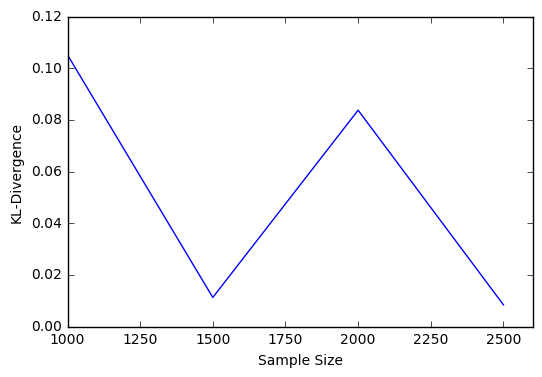

In [18]:
import matplotlib.pyplot as plt

plt.plot([1000, 1500, 2000, 2500], [klOne, klTwo, klThree, klFour])
plt.xlabel("Sample Size")
plt.ylabel("KL-Divergence")
plt.xticks([1000, 1250, 1500,1750, 2000, 2250, 2500])
plt.show()
